<a href="https://colab.research.google.com/github/garypapa/ML/blob/main/Exercise_7_Papadopoulou_Garyfallia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB

#Question 1

In [ ]:
df = pd.read_csv("train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_df, test_df = train_test_split(
    df,
    test_size=0.10,
    stratify=df["target"],
    random_state=0
)

print(train_df.shape, test_df.shape)

(6851, 5) (762, 5)


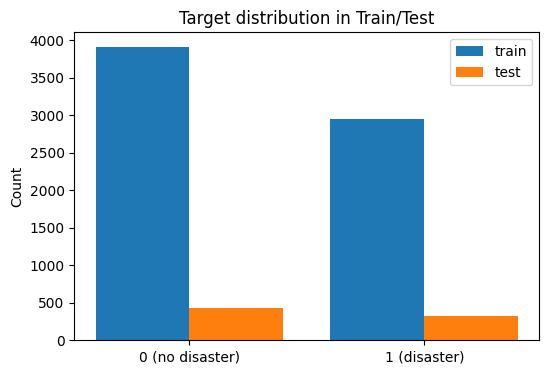

Train counts:
 target
0    3907
1    2944
Name: count, dtype: int64
Test counts:
 target
0    435
1    327
Name: count, dtype: int64


In [ ]:
train_counts = train_df["target"].value_counts().sort_index()
test_counts  = test_df["target"].value_counts().sort_index()

labels = ["0 (no disaster)", "1 (disaster)"]
x = range(len(labels))

plt.figure(figsize=(6,4))
plt.bar([i - 0.2 for i in x], train_counts.values, width=0.4, label="train")
plt.bar([i + 0.2 for i in x], test_counts.values,  width=0.4, label="test")
plt.xticks(list(x), labels)
plt.ylabel("Count")
plt.title("Target distribution in Train/Test")
plt.legend()
plt.show()

print("Train counts:\n", train_counts)
print("Test counts:\n", test_counts)

In [ ]:
print("Train %:\n", train_df["target"].value_counts(normalize=True))
print("Test %:\n", test_df["target"].value_counts(normalize=True))

Train %:
 target
0    0.570282
1    0.429718
Name: proportion, dtype: float64
Test %:
 target
0    0.570866
1    0.429134
Name: proportion, dtype: float64


The stratify=target parameter keeps the same class distribution in both the training and test sets as in the original dataset. This is confirmed by the almost identical class percentages in the train and test sets (about 57% for target=0 and 43% for target=1), showing that the stratified split worked correctly.

#Question 2

In [ ]:
train_df = train_df.drop(columns=["id", "location"])
test_df  = test_df.drop(columns=["id", "location"])
train_df = train_df.fillna("null")
test_df  = test_df.fillna("null")
train_df["inputs"] = train_df["keyword"] + " " + train_df["text"]
test_df["inputs"]  = test_df["keyword"] + " " + test_df["text"]

train_df[["keyword", "text", "inputs"]].head()

,keyword,text,inputs
6669,threat,Meek Mill responds to DrakeÛªs OVO Fest set w...,threat Meek Mill responds to DrakeÛªs OVO Fes...
3940,flood,survived the plague\nfloated the flood\njust p...,flood survived the plague\nfloated the flood\n...
7217,weapons,#Kick Hendrixonfire @'=BLACKCATS= | BIG NOOB ...,weapons #Kick Hendrixonfire @'=BLACKCATS= | B...
2234,deluge,Vince McMahon once again a billionaire: I reme...,deluge Vince McMahon once again a billionaire:...
4233,hazardous,Is it possible to sneak into a hospital so I c...,hazardous Is it possible to sneak into a hospi...


#Question 3

In [ ]:
train_df["inputs"].head(20)

,inputs
6669,threat Meek Mill responds to DrakeÛªs OVO Fes...
3940,flood survived the plague\nfloated the flood\n...
7217,weapons #Kick Hendrixonfire @'=BLACKCATS= | B...
2234,deluge Vince McMahon once again a billionaire:...
4233,hazardous Is it possible to sneak into a hospi...
6050,sinkhole Large sinkhole swallows entire pond i...
6518,survive It's going on three years that we have...
1290,burned @thomasvissman22 @KeithyyL Keithyy gett...
5967,screaming @MissDaOh and if she had a screaming...
2623,destruction Don't be the cause of your own sel...


In [ ]:
print("URLs:")
print(train_df["inputs"].str.contains("http|www", regex=True).sum())

print("\n@:")
print(train_df["inputs"].str.contains("@", regex=False).sum())

print("\n#:")
print(train_df["inputs"].str.contains("#", regex=False).sum())

print("\nnumbers:")
print(train_df["inputs"].str.contains(r"\d", regex=True).sum())

print("\nnon-ASCII characters:")
print(train_df["inputs"].str.contains(r"[^\x00-\x7f]", regex=True).sum())

URLs:
3576

@:
1835

#:
1600

numbers:
4483

non-ASCII characters:
620


In [ ]:
def removeUnicode(text):
    text = re.sub(r'(\\u[0-9A-Fa-f]+)', r'', text)
    text = re.sub(r'[^\x00-\x7f]', r'', text)
    return text

def replaceURL(text):
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', 'url', text)
    return text

def replaceAtUser(text):
    text = re.sub(r'@[^\s]+', 'atUser', text)
    return text

def removeHashtagInFrontOfWord(text):
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

def removeNumbers(text):
    return ''.join([c for c in text if not c.isdigit()])

def removeEmoticons(text):
    text = re.sub(
        r':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|'
        r'\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|'
        r':O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:',
        '',
        text
    )
    return text

In [ ]:
def clean_text(text):
    text = removeUnicode(text)
    text = replaceURL(text)
    text = replaceAtUser(text)
    text = removeHashtagInFrontOfWord(text)
    text = removeNumbers(text)
    text = removeEmoticons(text)
    text = text.lower()
    return text

train_clean = train_df.copy()
test_clean  = test_df.copy()

train_clean["inputs"] = train_clean["inputs"].apply(clean_text)
test_clean["inputs"]  = test_clean["inputs"].apply(clean_text)

In [ ]:
print("Original text:")
print(train_df["inputs"].iloc[0])

print("\nCleaned text:")
print(train_clean["inputs"].iloc[0])

Original text:
threat Meek Mill responds to DrakeÛªs OVO Fest set with wedgie threat http://t.co/qqSKYbARNg

Cleaned text:
threat meek mill responds to drakes ovo fest set with wedgie threat url


*   **removeUnicode**: This technique was used to remove non-ASCII characters and unicode symbols that appear in tweets and add noise to the text.
*   **replaceURL**: URLs were replaced with a common token because they appear frequently in tweets but do not provide useful information for disaster classification.
*   **replaceAtUser**: User mentions were replaced since usernames do not carry semantic meaning related to the content of the tweet.
*   **removeHashtagInFrontOfWord**: The hashtag symbol was removed while keeping the word, as hashtags are common in tweets and the word itself is still informative.
*  **removeNumbers**: Numbers were removed because they often appear in tweets but usually do not contribute to understanding whether a disaster is occurring.
*   **removeEmoticons**: Emoticons and emojis were removed to reduce noise, as they are not directly useful for the classification task.

#Question 4

In [ ]:
X_train = train_clean["inputs"].values
y_train = train_clean["target"].values

X_test = test_clean["inputs"].values
y_test = test_clean["target"].values

print(type(X_train), type(y_train))
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
X_train shape: (6851,)
y_train shape: (6851,)


#Question 5

In [ ]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

print("Train TF-IDF shape:", X_train_tfidf.shape)
print("Test TF-IDF shape:", X_test_tfidf.shape)

Train TF-IDF shape: (6851, 13500)
Test TF-IDF shape: (762, 13500)


#Question 6

In [ ]:
linear_svc = LinearSVC(random_state=0)
linear_svc.fit(X_train_tfidf, y_train)

y_train_pred = linear_svc.predict(X_train_tfidf)
y_test_pred  = linear_svc.predict(X_test_tfidf)

def compute_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred)
    }

train_metrics_linear = compute_metrics(y_train, y_train_pred)
test_metrics_linear  = compute_metrics(y_test, y_test_pred)

print("Train metrics:", train_metrics_linear)
print("Test metrics:", test_metrics_linear)

results = {}

results["LinearSVC"] = test_metrics_linear

Train metrics: {'accuracy': 0.9613195153992118, 'precision': 0.9755058572949947, 'recall': 0.9334239130434783, 'f1': 0.9540010414858532}
Test metrics: {'accuracy': 0.800524934383202, 'precision': 0.7850162866449512, 'recall': 0.7370030581039755, 'f1': 0.7602523659305994}


In this application, recall is the most important metric because the goal is to detect ongoing natural disasters. Missing a real disaster-related tweet (false negative) could prevent an alert from being sent, which may have serious consequences. Therefore, it is more important to correctly identify as many real disaster cases as possible, even if this leads to some false positives.

#Question 7

In [ ]:
X_train_dense = X_train_tfidf.toarray()
X_test_dense  = X_test_tfidf.toarray()

pca = PCA(n_components=0.95, random_state=0)

X_train_pca = pca.fit_transform(X_train_dense)
X_test_pca  = pca.transform(X_test_dense)

print("Original number of features:", X_train_tfidf.shape[1])
print("Number of PCA components:", X_train_pca.shape[1])
print("Explained variance ratio:", pca.explained_variance_ratio_.sum())

Original number of features: 13500
Number of PCA components: 3730
Explained variance ratio: 0.9500112237356646


In [ ]:
linear_svc_pca = LinearSVC(random_state=0)
linear_svc_pca.fit(X_train_pca, y_train)

y_test_pred_linear_pca = linear_svc_pca.predict(X_test_pca)

test_metrics_linear_pca = compute_metrics(y_test, y_test_pred_linear_pca)

print("LinearSVC + PCA (test):", test_metrics_linear_pca)

results["LinearSVC + PCA"] = test_metrics_linear_pca

LinearSVC + PCA (test): {'accuracy': 0.8097112860892388, 'precision': 0.7954545454545454, 'recall': 0.7492354740061162, 'f1': 0.7716535433070866}


In [ ]:
svc_rbf_pca = SVC(kernel="rbf", random_state=0)
svc_rbf_pca.fit(X_train_pca, y_train)

y_test_pred_rbf_pca = svc_rbf_pca.predict(X_test_pca)

test_metrics_rbf_pca = compute_metrics(y_test, y_test_pred_rbf_pca)

print("SVC (RBF) + PCA (test):", test_metrics_rbf_pca)

results["SVC (RBF) + PCA"] = test_metrics_rbf_pca

SVC (RBF) + PCA (test): {'accuracy': 0.8149606299212598, 'precision': 0.803921568627451, 'recall': 0.7522935779816514, 'f1': 0.7772511848341233}


After applying PCA, both models achieved similar performance; however, the SVC with RBF kernel slightly outperformed the LinearSVC in terms of accuracy, precision, recall, and F1-score. This indicates that the non-linear RBF kernel benefits more from the reduced feature space provided by PCA.

#Question 8

The default value gamma='scale' is computed as the inverse of the product of the number of features and the variance of the data, while gamma='auto' is computed as the inverse of the number of features only.

In [ ]:
svc_rbf_pca_auto = SVC(kernel="rbf", gamma="auto", random_state=0)
svc_rbf_pca_auto.fit(X_train_pca, y_train)

y_test_pred_rbf_pca_auto = svc_rbf_pca_auto.predict(X_test_pca)

test_metrics_rbf_pca_auto = compute_metrics(y_test, y_test_pred_rbf_pca_auto)

print("SVC (RBF, gamma=auto) + PCA (test):", test_metrics_rbf_pca_auto)

results["SVC (RBF, gamma=auto) + PCA"] = test_metrics_rbf_pca_auto

SVC (RBF, gamma=auto) + PCA (test): {'accuracy': 0.5708661417322834, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


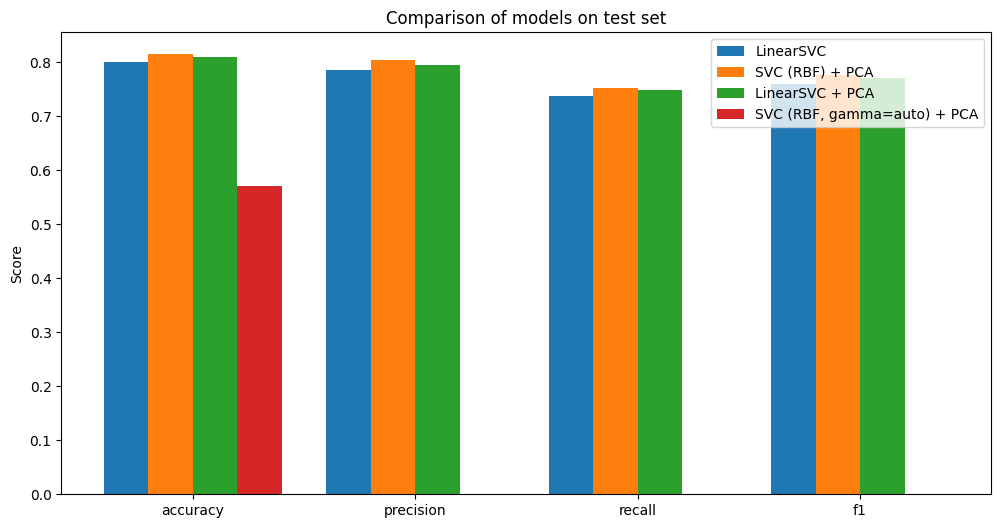

In [ ]:
models = list(results.keys())
metrics = ["accuracy", "precision", "recall", "f1"]

values = {model: [results[model][m] for m in metrics] for model in models}

x = np.arange(len(metrics))
width = 0.2

plt.figure(figsize=(12,6))

for i, model in enumerate(models):
    plt.bar(x + i*width, values[model], width, label=model)

plt.xticks(x + width*(len(models)-1)/2, metrics)
plt.ylabel("Score")
plt.title("Comparison of models on test set")
plt.legend()
plt.show()

The SVC with RBF kernel and gamma='scale' achieves the best overall performance across all metrics. LinearSVC models perform slightly worse, while the SVC with gamma='auto' shows very poor performance, failing to correctly identify positive samples. This highlights the importance of proper hyperparameter selection.

#Question 9

In [ ]:
X_train_dense_nb = X_train_tfidf.toarray()
X_test_dense_nb  = X_test_tfidf.toarray()

gnb = GaussianNB()
gnb.fit(X_train_dense_nb, y_train)

y_train_pred_nb = gnb.predict(X_train_dense_nb)
y_test_pred_nb  = gnb.predict(X_test_dense_nb)

train_metrics_nb = compute_metrics(y_train, y_train_pred_nb)
test_metrics_nb  = compute_metrics(y_test, y_test_pred_nb)

print("GaussianNB - Train metrics:", train_metrics_nb)
print("GaussianNB - Test metrics:", test_metrics_nb)

results["GaussianNB (no PCA)"] = test_metrics_nb

GaussianNB - Train metrics: {'accuracy': 0.8794336593198073, 'precision': 0.7809018567639258, 'recall': 1.0, 'f1': 0.8769734882335418}
GaussianNB - Test metrics: {'accuracy': 0.6181102362204725, 'precision': 0.5368852459016393, 'recall': 0.8012232415902141, 'f1': 0.6429447852760736}


The model achieved high recall but relatively low precision and accuracy, indicating that it detects most disaster-related tweets but also produces many false positives. Overall, its performance is lower than the SVM-based models, which is expected due to the strong independence assumptions of Naive Baye